In [1]:
%load_ext autoreload
%load_ext notexbook
%autoreload 2
%load_ext autotime

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm
import networkx as nx

plt.style.use("../config/custom_plt.mplstyle")

colors = [
    "#7494d3",
    "#5cb545",
    "#9956c6",
    "#a7b338",
    "#6a6bc6",
    "#d09e40",
    "#ce62bb",
    "#56be85",
    "#d1477d",
    "#397f4d",
    "#cf4b4a",
    "#40bbc1",
    "#d8662c",
    "#99af66",
    "#b76989",
    "#6d7127",
    "#b6744a"
]

time: 1.3 s (started: 2023-05-10 15:14:03 +02:00)


In [2]:
# %texify --code-font-family Monaco --linespread 1.2 --code-font-size 13

time: 632 µs (started: 2023-05-10 15:14:05 +02:00)


In [3]:
df_homophily = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/homophily_datasets_new_with_metrics.csv")

time: 7.75 ms (started: 2023-05-10 15:14:05 +02:00)


In [4]:
df_similarity = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/similarity_datasets.csv")

time: 4.78 ms (started: 2023-05-10 15:14:05 +02:00)


In [5]:
df_all = df_homophily.merge(df_similarity)
# df_all = df_homophily
# removed_columns = ['acm', 'twitch_ru', 'twitch_de'] # datasets where beta could not be inferred (too low or too large)
# df_all = df_all[~df_all['dataset'].isin(removed_columns)]
df_all

,dataset,H_node,H_edge,C,l,r,k,similarity
0,citeseer,0.714119,0.736369,0.171070,9.310487,0.007137,3.476777,0.636876
1,cora,0.814498,0.804103,0.237636,6.310999,-0.071365,4.079678,0.685451
2,film,0.221966,0.219460,0.080193,4.110280,-0.046871,7.040000,0.387369
3,dblp,0.734636,0.744707,0.638952,3.476752,0.308222,31.442815,0.630028
4,imdb,0.462170,0.446323,0.526589,3.700298,0.468194,19.455390,0.490794
5,amazon_photo,0.848826,0.827205,0.410459,4.050997,-0.045047,31.799920,0.752339
6,cornell,0.118240,0.132143,0.167080,3.200564,-0.246913,3.060109,0.365983
7,wisconsin,0.170690,0.206009,0.207679,3.259952,-0.190340,3.713147,0.393578
8,texas,0.087281,0.111864,0.197926,3.036210,-0.264722,3.224044,0.355870
9,lastfm,0.833171,0.873876,0.219418,5.232237,0.017073,7.294334,0.714815


time: 25.1 ms (started: 2023-05-10 15:14:05 +02:00)


- 1  --  citeseer
- 2  --  cora
- 3  --  film
- 4  --  dblp
- 5  --  imdb
- ?  --  acm [x]
- 6  --  amazon_photo
- 7  --  cornell
- 8  --  wisconsin
- 9  --  texas
- 10  --  lastfm
- ?  --  twitch_ru [x]
- 11  --  twitch_ptbr
- 12  --  twitch_fr
- 13  --  twitch_es
- 14  --  twitch_engb
- ?  --  twitch_de [x]

In [23]:
from sklearn.preprocessing import LabelEncoder
import networkx.algorithms.community as nx_comm

def load_results(inf_coords_path, labels, g):
    inf_coords = pd.read_csv(inf_coords_path, comment="#", header=None, sep="\s+")
    inf_coords.columns = ['index', 'kappa', 'hyp_rad', 'p1', 'p2', 'p3']
    inf_coords['index'] = inf_coords['index'].astype(str)
    inf_coords = inf_coords.merge(labels, on="index")
    le = LabelEncoder()
    inf_coords['encoded_label'] = le.fit_transform(inf_coords['label'])
    inf_coords = inf_coords.drop_duplicates(subset=['index'])
        
    # Louvain communities
    communities = nx_comm.louvain_communities(g, seed=123)
    communities_dict = []
    for i, com in enumerate(communities):
        communities_dict.append({c:i for c in com})

    result = {}
    for d in communities_dict:
        result.update(d)

    communities_louvain = pd.DataFrame()
    communities_louvain['index'] = result.keys()
    communities_louvain['label_louvain'] = result.values()

    inf_coords = inf_coords.merge(communities_louvain, on='index')        
    print('Number of communities from Louvain: ', len(np.unique(inf_coords['label_louvain'])))
    
    # Shuffle labels -> create a baseline for node classification
    inf_coords['label_louvain'] = np.random.permutation(inf_coords['label_louvain'])
    
    return inf_coords

time: 2.1 ms (started: 2023-05-10 15:26:16 +02:00)


In [24]:
citeseer_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer_GC_fixed.edge")
citeseer_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer.content", header=None, sep="\s+", low_memory=False)
citeseer_labels = pd.DataFrame()
citeseer_labels['index'] = citeseer_features.iloc[:, 0].astype(str)
citeseer_labels['label'] = citeseer_features.iloc[:, -1]

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap"
citeseer_le_ml = load_results(f"{base_path}/le_ml/citeseer_GC_fixed.inf_coord", citeseer_labels, citeseer_graph)
citeseer_umap_ml = load_results(f"{base_path}/umap_ml/citeseer_GC_fixed.inf_coord", citeseer_labels, citeseer_graph)
citeseer_random_ml = load_results(f"{base_path}/random/citeseer_GC_fixed.inf_coord", citeseer_labels, citeseer_graph)
citeseer_only_umap = load_results(f"{base_path}/only_umap/citeseer_GC_fixed.inf_coord", citeseer_labels, citeseer_graph)

Number of communities from Louvain:  37
Number of communities from Louvain:  37
Number of communities from Louvain:  37
Number of communities from Louvain:  37
time: 59.3 s (started: 2023-05-10 15:26:16 +02:00)


In [25]:
cora_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/cora_GC.edge")
cora_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/cora.content", header=None, sep="\s+", low_memory=False)
cora_labels = pd.DataFrame()
cora_labels['index'] = cora_features.iloc[:, 0].astype(str)
cora_labels['label'] = cora_features.iloc[:, -1]

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/"
cora_le_ml = load_results(f"{base_path}/le_ml/cora_GC.inf_coord", cora_labels, cora_graph)
cora_umap_ml = load_results(f"{base_path}/umap_ml/cora_GC.inf_coord", cora_labels, cora_graph)
cora_random_ml = load_results(f"{base_path}/random/cora_GC.inf_coord", cora_labels, cora_graph)
cora_only_umap = load_results(f"{base_path}/only_umap/cora_GC.inf_coord", cora_labels, cora_graph)

Number of communities from Louvain:  27
Number of communities from Louvain:  27
Number of communities from Louvain:  27
Number of communities from Louvain:  27
time: 1.26 s (started: 2023-05-10 15:27:15 +02:00)


In [26]:
dblp_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/dblp_pprefp/eS1/dblp_pprefp_GC.edge")
dblp_labels = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/dblp_label.txt")
dblp_labels = np.argmax(dblp_labels, axis=1)
dblp_labels_dict = pd.DataFrame()
dblp_labels_dict['label'] = dblp_labels
dblp_labels_dict = dblp_labels_dict.reset_index()
dblp_labels_dict['index'] = dblp_labels_dict['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/"
dblp_le_ml = load_results(f"{base_path}/le_ml/dblp_pprefp_GC.inf_coord", dblp_labels_dict, dblp_graph)
dblp_umap_ml = load_results(f"{base_path}/umap_ml/dblp_pprefp_GC.inf_coord", dblp_labels_dict, dblp_graph)
dblp_random_ml = load_results(f"{base_path}/random/dblp_pprefp_GC.inf_coord", dblp_labels_dict, dblp_graph)
dblp_only_umap = load_results(f"{base_path}/only_umap/dblp_pprefp_GC.inf_coord", dblp_labels_dict, dblp_graph)

Number of communities from Louvain:  18
Number of communities from Louvain:  18
Number of communities from Louvain:  18
Number of communities from Louvain:  18
time: 3.15 s (started: 2023-05-10 15:27:17 +02:00)


In [27]:
imdb_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/imdb_mam/eS1/imdb_mam_GC.edge")
imdb_labels = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/imdb_label.txt")
imdb_labels = np.argmax(imdb_labels, axis=1)
imdb_labels_dict = pd.DataFrame()
imdb_labels_dict['label'] = imdb_labels
imdb_labels_dict = imdb_labels_dict.reset_index()
imdb_labels_dict['index'] = imdb_labels_dict['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/"
imdb_le_ml = load_results(f"{base_path}/le_ml/imdb_mam_GC.inf_coord", imdb_labels_dict, imdb_graph)
imdb_umap_ml = load_results(f"{base_path}/umap_ml/imdb_mam_GC.inf_coord", imdb_labels_dict, imdb_graph)
imdb_random_ml = load_results(f"{base_path}/random/imdb_mam_GC.inf_coord", imdb_labels_dict, imdb_graph)
imdb_only_umap = load_results(f"{base_path}/only_umap/imdb_mam_GC.inf_coord", imdb_labels_dict, imdb_graph)

Number of communities from Louvain:  27
Number of communities from Louvain:  27
Number of communities from Louvain:  27
Number of communities from Louvain:  27
time: 3.05 s (started: 2023-05-10 15:27:20 +02:00)


In [28]:
amazon_photo_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/amazon_photo_GC.edge")
amazon_photo_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/amazon_photo_labels.txt", header=None)
amazon_photo_labels.reset_index(inplace=True)
amazon_photo_labels.columns = ['index', 'label']
amazon_photo_labels['index'] = amazon_photo_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/"
amazon_photo_le_ml = load_results(f"{base_path}/le_ml/amazon_photo_GC.inf_coord", amazon_photo_labels, amazon_photo_graph)
amazon_photo_umap_ml = load_results(f"{base_path}/umap_ml/amazon_photo_GC.inf_coord", amazon_photo_labels, amazon_photo_graph)
amazon_photo_random_ml = load_results(f"{base_path}/random/amazon_photo_GC.inf_coord", amazon_photo_labels, amazon_photo_graph)
amazon_photo_only_umap = load_results(f"{base_path}/only_umap/amazon_photo_GC.inf_coord", amazon_photo_labels, amazon_photo_graph)

Number of communities from Louvain:  14
Number of communities from Louvain:  14
Number of communities from Louvain:  14
Number of communities from Louvain:  14
time: 12.1 s (started: 2023-05-10 15:27:23 +02:00)


In [29]:
cornell_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/out1_graph_edges.edge")
cornell_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/out1_node_feature_label.txt", sep="\s+")
cornell_labels = pd.DataFrame()
cornell_labels['index'] = cornell_features['node_id']
cornell_labels['label'] = cornell_features['label']
cornell_labels['index'] = cornell_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/"
cornell_le_ml = load_results(f"{base_path}/le_ml/out1_graph_edges.inf_coord", cornell_labels, cornell_graph)
cornell_umap_ml = load_results(f"{base_path}/umap_ml/out1_graph_edges.inf_coord", cornell_labels, cornell_graph)
cornell_random_ml = load_results(f"{base_path}/random/out1_graph_edges.inf_coord", cornell_labels, cornell_graph)
cornell_only_umap = load_results(f"{base_path}/only_umap/out1_graph_edges.inf_coord", cornell_labels, cornell_graph)

Number of communities from Louvain:  14
Number of communities from Louvain:  14
Number of communities from Louvain:  14
Number of communities from Louvain:  14
time: 108 ms (started: 2023-05-10 15:27:35 +02:00)


In [30]:
wisconsin_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/out1_graph_edges.edge")
wisconsin_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/out1_node_feature_label.txt", sep="\s+")
wisconsin_labels = pd.DataFrame()
wisconsin_labels['index'] = wisconsin_features['node_id']
wisconsin_labels['label'] = wisconsin_features['label']
wisconsin_labels['index'] = wisconsin_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/"
wisconsin_le_ml = load_results(f"{base_path}/le_ml/out1_graph_edges.inf_coord", wisconsin_labels, wisconsin_graph)
wisconsin_umap_ml = load_results(f"{base_path}/umap_ml/out1_graph_edges.inf_coord", wisconsin_labels, wisconsin_graph)
wisconsin_random_ml = load_results(f"{base_path}/random/out1_graph_edges.inf_coord", wisconsin_labels, wisconsin_graph)
wisconsin_only_umap = load_results(f"{base_path}/only_umap/out1_graph_edges.inf_coord", wisconsin_labels, wisconsin_graph)

Number of communities from Louvain:  12
Number of communities from Louvain:  12
Number of communities from Louvain:  12
Number of communities from Louvain:  12
time: 246 ms (started: 2023-05-10 15:27:35 +02:00)


In [31]:
texas_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/out1_graph_edges.edge")
texas_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/out1_node_feature_label.txt", sep="\s+")
texas_labels = pd.DataFrame()
texas_labels['index'] = texas_features['node_id']
texas_labels['label'] = texas_features['label']
texas_labels['index'] = texas_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/"
texas_le_ml = load_results(f"{base_path}/le_ml/out1_graph_edges.inf_coord", texas_labels, texas_graph)
texas_umap_ml = load_results(f"{base_path}/umap_ml/out1_graph_edges.inf_coord", texas_labels, texas_graph)
texas_random_ml = load_results(f"{base_path}/random/out1_graph_edges.inf_coord", texas_labels, texas_graph)
texas_only_umap = load_results(f"{base_path}/only_umap/out1_graph_edges.inf_coord", texas_labels, texas_graph)

Number of communities from Louvain:  12
Number of communities from Louvain:  12
Number of communities from Louvain:  12
Number of communities from Louvain:  12
time: 128 ms (started: 2023-05-10 15:27:36 +02:00)


In [32]:
lastfm_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/lastfm_asia_edges/eS1/lastfm_asia_edges.edge")
lastfm_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/lastfm_asia_target.csv")
lastfm_labels.columns = ['index', 'label']
lastfm_labels['index'] = lastfm_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/"
lastfm_le_ml = load_results(f"{base_path}/le_ml/lastfm_asia_edges.inf_coord", lastfm_labels, lastfm_graph)
lastfm_umap_ml = load_results(f"{base_path}/umap_ml/lastfm_asia_edges.inf_coord", lastfm_labels, lastfm_graph)
lastfm_random_ml = load_results(f"{base_path}/random/lastfm_asia_edges.inf_coord", lastfm_labels, lastfm_graph)
lastfm_only_umap = load_results(f"{base_path}/only_umap/lastfm_asia_edges.inf_coord", lastfm_labels, lastfm_graph)

Number of communities from Louvain:  29
Number of communities from Louvain:  29
Number of communities from Louvain:  29
Number of communities from Louvain:  29
time: 4.81 s (started: 2023-05-10 15:27:36 +02:00)


In [33]:
twitch_ptbr_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/musae_PTBR_edges.edge")
twitch_ptbr_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/musae_PTBR_target.csv")
twitch_ptbr_labels['label'] = twitch_ptbr_labels['mature'].astype(int)
twitch_ptbr_labels = twitch_ptbr_labels[['new_id', 'label']]
twitch_ptbr_labels['index'] = twitch_ptbr_labels['new_id']
twitch_ptbr_labels.insert(0, 'index', twitch_ptbr_labels.pop('index'))
twitch_ptbr_labels['index'] = twitch_ptbr_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/"
twitch_ptbr_le_ml = load_results(f"{base_path}/le_ml/musae_PTBR_edges.inf_coord", twitch_ptbr_labels, twitch_ptbr_graph)
twitch_ptbr_umap_ml = load_results(f"{base_path}/umap_ml/musae_PTBR_edges.inf_coord", twitch_ptbr_labels, twitch_ptbr_graph)
twitch_ptbr_random_ml = load_results(f"{base_path}/random/musae_PTBR_edges.inf_coord", twitch_ptbr_labels, twitch_ptbr_graph)
twitch_ptbr_only_umap = load_results(f"{base_path}/only_umap/musae_PTBR_edges.inf_coord", twitch_ptbr_labels, twitch_ptbr_graph)

Number of communities from Louvain:  8
Number of communities from Louvain:  8
Number of communities from Louvain:  8
Number of communities from Louvain:  8
time: 2.54 s (started: 2023-05-10 15:27:41 +02:00)


## Node classification

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# before: test_size=0.8

def node_classification(df_le_ml, df_umap_ml, df_random_ml, df_only_umap, test_size=0.2, n_times=5):
    pos_le_ml = df_le_ml[['p1', 'p2', 'p3']].values
    pos_umap_ml = df_umap_ml[['p1', 'p2', 'p3']].values
    pos_random_ml = df_random_ml[['p1', 'p2', 'p3']].values
    pos_only_umap = df_only_umap[['p1', 'p2', 'p3']].values
    
    f1_le_ml, accuracy_le_ml = [], []
    f1_umap_ml, accuracy_umap_ml = [], []
    f1_random_ml, accuracy_random_ml = [], []
    f1_only_umap, accuracy_only_umap = [], []
    
    for _ in tqdm(range(n_times)):
        y_pred, y_true = predict_labels_kneighbours(pos_le_ml, df_le_ml['label_louvain'].values, test_size)
        f1_le_ml.append(f1_score(y_true, y_pred, average='micro'))
        accuracy_le_ml.append(accuracy_score(y_true, y_pred))

        y_pred, y_true = predict_labels_kneighbours(pos_umap_ml, df_umap_ml['label_louvain'].values, test_size)
        f1_umap_ml.append(f1_score(y_true, y_pred, average='micro'))
        accuracy_umap_ml.append(accuracy_score(y_true, y_pred))
        
        y_pred, y_true = predict_labels_kneighbours(pos_random_ml, df_random_ml['label_louvain'].values, test_size)
        f1_random_ml.append(f1_score(y_true, y_pred, average='micro'))
        accuracy_random_ml.append(accuracy_score(y_true, y_pred))
        
        y_pred, y_true = predict_labels_kneighbours(pos_only_umap, df_only_umap['label_louvain'].values, test_size)
        f1_only_umap.append(f1_score(y_true, y_pred, average='micro'))
        accuracy_only_umap.append(accuracy_score(y_true, y_pred))
        
    return {
        'f1_le_ml': f1_le_ml,
        'f1_umap_ml': f1_umap_ml,
        'f1_random_ml': f1_random_ml,
        'f1_only_umap': f1_only_umap,
        'accuracy_le_ml': accuracy_le_ml,
        'accuracy_umap_ml': accuracy_umap_ml,
        'accuracy_random_ml': accuracy_random_ml,
        'accuracy_only_umap': accuracy_only_umap
    }


def predict_labels(pos, labels, test_size):
    pos_train, pos_test, labels_train, labels_test = train_test_split(pos, labels, test_size=test_size)
    predicted_labels = []

    for p_test in tqdm(pos_test):
        smallest_angle = 1e8
        smallest_idx = 0
        for i, p_train in enumerate(pos_train):
            angle = np.arccos(np.dot(p_test, p_train) / (np.linalg.norm(p_test) * np.linalg.norm(p_train)))
            if angle < smallest_angle:
                smallest_angle = angle
                smallest_idx = i
        predicted_labels.append(labels_train[smallest_idx])

    predicted_labels = np.array(predicted_labels)
    return predicted_labels, labels_test



def predict_labels_kneighbours(pos, labels, test_size, k_neighbours=5):
    pos_train, pos_test, labels_train, labels_test = train_test_split(pos, labels, test_size=test_size)
    
    neigh = KNeighborsClassifier(n_neighbors=k_neighbours, metric=compute_angle)
    neigh.fit(pos_train, labels_train)
    
    predicted_labels = neigh.predict(pos_test)
    return predicted_labels, labels_test
    
    
def compute_angle(p1, p2):
    return np.arccos(np.clip(np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2)), -1, 1))

time: 3.74 ms (started: 2023-05-10 15:27:43 +02:00)


In [35]:
%%time

citeseer_nc = node_classification(citeseer_le_ml, citeseer_umap_ml, citeseer_random_ml, citeseer_only_umap)
cora_nc = node_classification(cora_le_ml, cora_umap_ml, cora_random_ml, cora_only_umap)
dblp_nc = node_classification(dblp_le_ml, dblp_umap_ml, dblp_random_ml, dblp_only_umap)
imdb_nc = node_classification(imdb_le_ml, imdb_umap_ml, imdb_random_ml, imdb_only_umap)
amazon_photo_nc = node_classification(amazon_photo_le_ml, amazon_photo_umap_ml, amazon_photo_random_ml, amazon_photo_only_umap)
cornell_nc = node_classification(cornell_le_ml, cornell_umap_ml, cornell_random_ml, cornell_only_umap)
wisconsin_nc = node_classification(wisconsin_le_ml, wisconsin_umap_ml, wisconsin_random_ml, wisconsin_only_umap)
texas_nc = node_classification(texas_le_ml, texas_umap_ml, texas_random_ml, texas_only_umap)
lastfm_nc = node_classification(lastfm_le_ml, lastfm_umap_ml, lastfm_random_ml, lastfm_only_umap)
twitch_ptbr_nc = node_classification(twitch_ptbr_le_ml, twitch_ptbr_umap_ml, twitch_ptbr_random_ml, twitch_ptbr_only_umap)

100%|██████████| 5/5 [00:32<00:00,  6.49s/it]

CPU times: user 9min 45s, sys: 219 ms, total: 9min 46s
Wall time: 9min 47s
time: 9min 47s (started: 2023-05-10 15:27:43 +02:00)


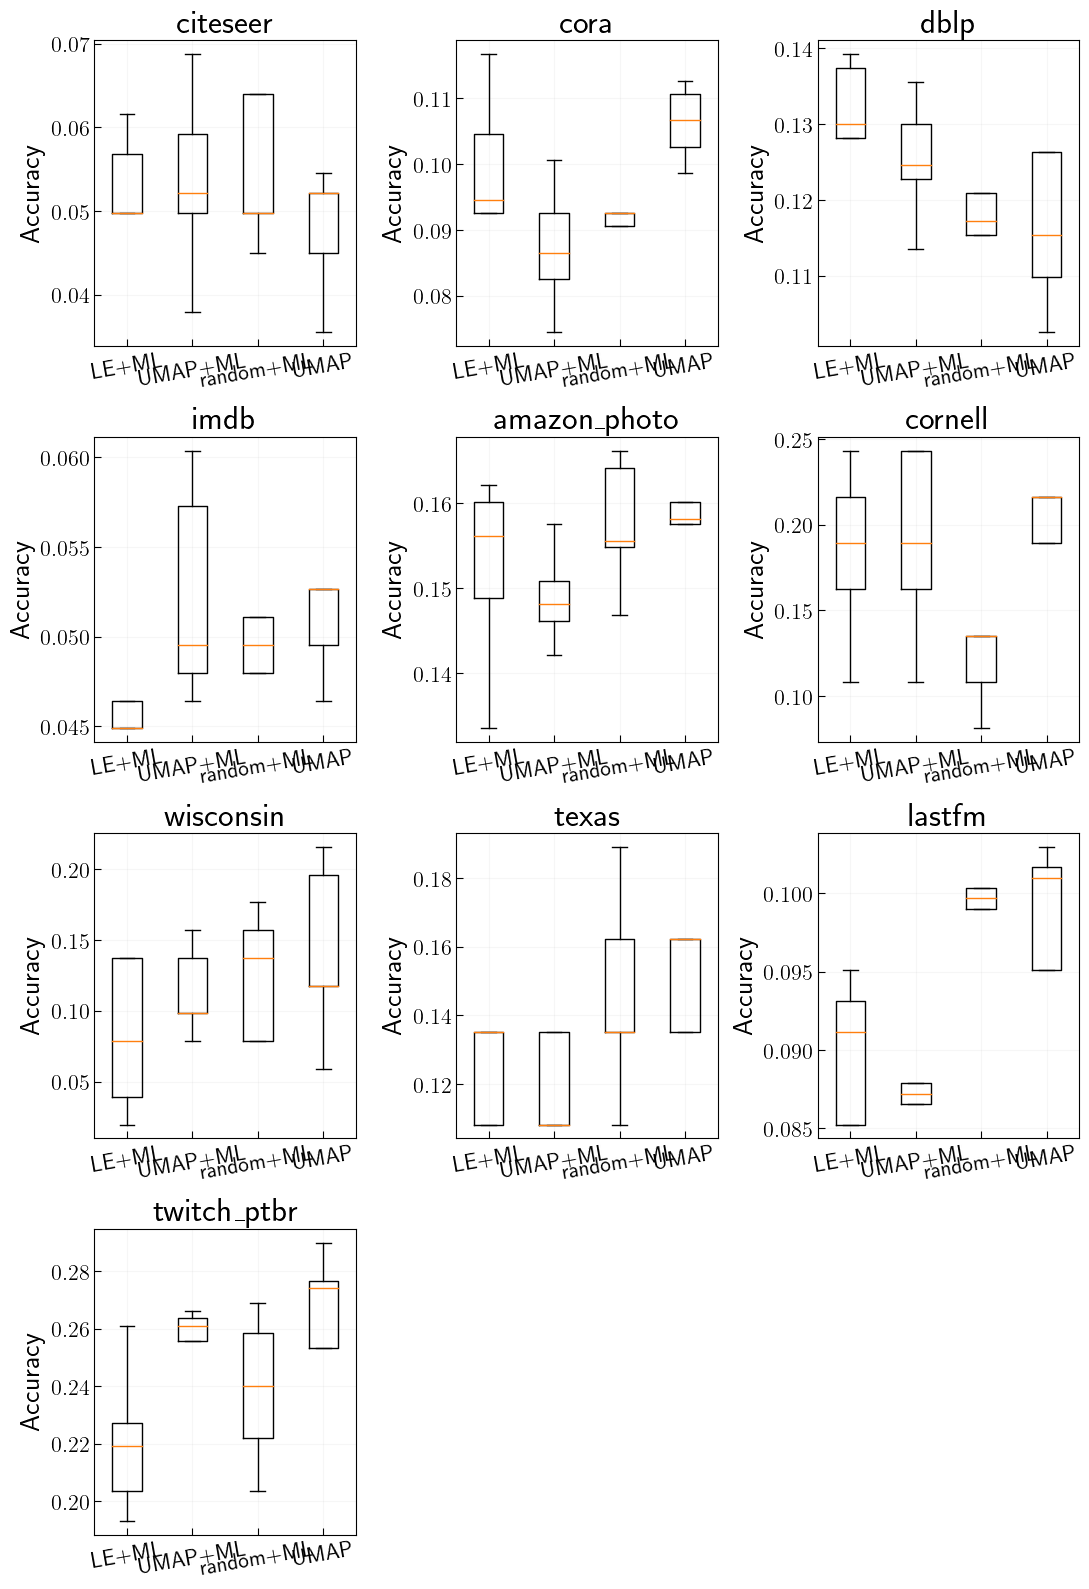

time: 956 ms (started: 2023-05-10 15:37:31 +02:00)


In [36]:
def plot_nc_per_dataset(nc, title):
    plt.boxplot([nc['accuracy_le_ml'], nc['accuracy_umap_ml'], nc['accuracy_random_ml'], nc['accuracy_only_umap']], showfliers=False)
    plt.xticks([1, 2, 3, 4], ['LE+ML', 'UMAP+ML', 'random+ML', 'UMAP'], rotation=10)
    plt.ylabel('Accuracy')
    plt.title(title)
    
plt.figure(figsize=(11, 16))

plt.subplot(4, 3, 1)
plot_nc_per_dataset(citeseer_nc, 'citeseer')
plt.subplot(4, 3, 2)
plot_nc_per_dataset(cora_nc, 'cora')
plt.subplot(4, 3, 3)
plot_nc_per_dataset(dblp_nc, 'dblp')
plt.subplot(4, 3, 4)
plot_nc_per_dataset(imdb_nc, 'imdb')
plt.subplot(4, 3, 5)
plot_nc_per_dataset(amazon_photo_nc, 'amazon_photo')
plt.subplot(4, 3, 6)
plot_nc_per_dataset(cornell_nc, 'cornell')
plt.subplot(4, 3, 7)
plot_nc_per_dataset(wisconsin_nc, 'wisconsin')
plt.subplot(4, 3, 8)
plot_nc_per_dataset(texas_nc, 'texas')
plt.subplot(4, 3, 9)
plot_nc_per_dataset(lastfm_nc, 'lastfm')
plt.subplot(4, 3, 10)
plot_nc_per_dataset(twitch_ptbr_nc, 'twitch_ptbr')

plt.tight_layout()


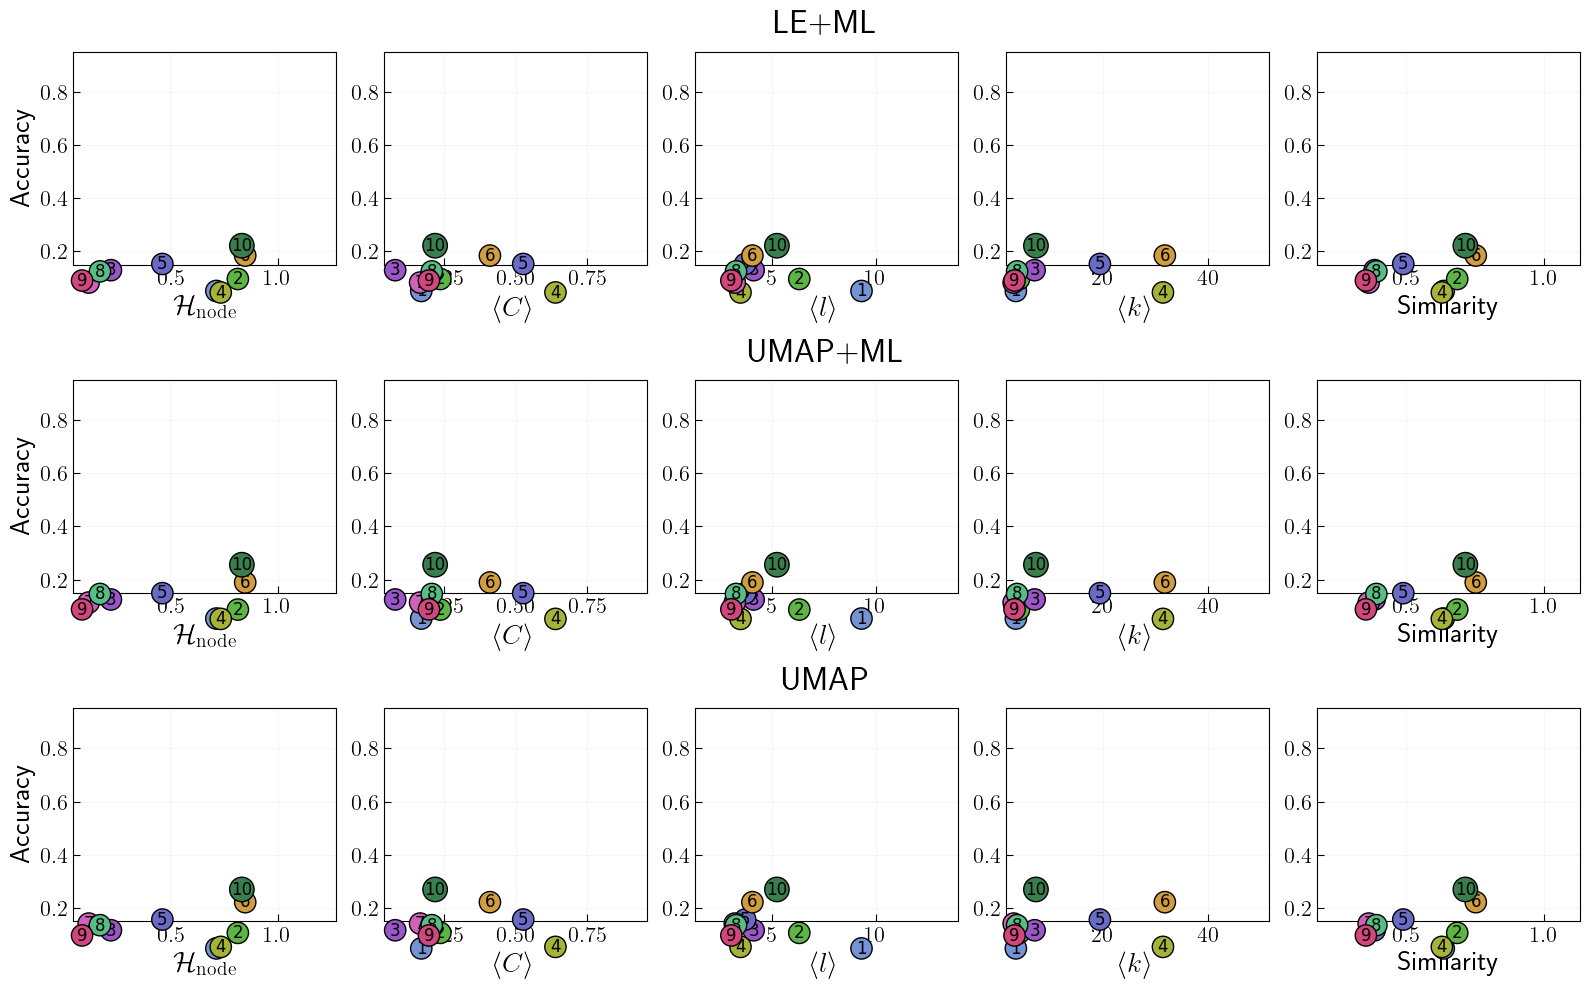

time: 1.44 s (started: 2023-05-10 15:37:32 +02:00)


In [37]:
nc_accuracy_le_ml = np.array([
    citeseer_nc['accuracy_le_ml'],
    cora_nc['accuracy_le_ml'],
    dblp_nc['accuracy_le_ml'],
    imdb_nc['accuracy_le_ml'],
    amazon_photo_nc['accuracy_le_ml'],
    cornell_nc['accuracy_le_ml'],
    wisconsin_nc['accuracy_le_ml'],
    texas_nc['accuracy_le_ml'],
    lastfm_nc['accuracy_le_ml'],
    twitch_ptbr_nc['accuracy_le_ml'],
])

nc_accuracy_umap_ml = np.array([
    citeseer_nc['accuracy_umap_ml'],
    cora_nc['accuracy_umap_ml'],
    dblp_nc['accuracy_umap_ml'],
    imdb_nc['accuracy_umap_ml'],
    amazon_photo_nc['accuracy_umap_ml'],
    cornell_nc['accuracy_umap_ml'],
    wisconsin_nc['accuracy_umap_ml'],
    texas_nc['accuracy_umap_ml'],    
    lastfm_nc['accuracy_umap_ml'],
    twitch_ptbr_nc['accuracy_umap_ml'],
])

nc_accuracy_random_ml = np.array([
    citeseer_nc['accuracy_random_ml'],
    cora_nc['accuracy_random_ml'],
    dblp_nc['accuracy_random_ml'],
    imdb_nc['accuracy_random_ml'],
    amazon_photo_nc['accuracy_random_ml'],
    cornell_nc['accuracy_random_ml'],
    wisconsin_nc['accuracy_random_ml'],
    texas_nc['accuracy_random_ml'],    
    lastfm_nc['accuracy_random_ml'],
    twitch_ptbr_nc['accuracy_random_ml'],
])

nc_accuracy_only_umap = np.array([
    citeseer_nc['accuracy_only_umap'],
    cora_nc['accuracy_only_umap'],
    dblp_nc['accuracy_only_umap'],
    imdb_nc['accuracy_only_umap'],
    amazon_photo_nc['accuracy_only_umap'],
    cornell_nc['accuracy_only_umap'],
    wisconsin_nc['accuracy_only_umap'],
    texas_nc['accuracy_only_umap'],
    lastfm_nc['accuracy_only_umap'],
    twitch_ptbr_nc['accuracy_only_umap'],
])

def plot_box_plot_per_option(nc_res, col):
    datasets = list(range(1, 15))
    for mean_acc, std_acc, h, c, name in zip(np.mean(nc_res, axis=1), np.std(nc_res, axis=1),
                                             df_all[col], colors, datasets):
        #plt.errorbar(h, mean_acc, yerr=std_acc, color=c, fmt='o')
        plt.text(h, mean_acc, name, ha="center", va="center",
                 bbox = dict(boxstyle=f"circle,pad=0.1", fc=c), fontsize=12, usetex=False)
    plt.ylim(0.15, 0.95)
    x = df_all[col]
    plt.xlim(min(x)-0.5*abs(min(x)), max(x)+0.5*abs(max(x)))
    
    
def plot_all_options_per_type(nc_res, title, i=1):
    plt.subplot(3, 5, i)
    plot_box_plot_per_option(nc_res, 'H_node')
    plt.xlabel(r'$\mathcal{H}_{\mathrm{node}}$')
    plt.ylabel('Accuracy')

    plt.subplot(3, 5, i+1)
    plot_box_plot_per_option(nc_res, 'C')
    plt.xlabel(r'$\left<C\right>$')

    plt.subplot(3, 5, i+2)
    plot_box_plot_per_option(nc_res, 'l')
    plt.xlabel(r'$\left<l\right>$')
    plt.title(title, y=1.05)

    plt.subplot(3, 5, i+3)
    plot_box_plot_per_option(nc_res, 'k')
    plt.xlabel(r'$\left<k\right>$')

    plt.subplot(3, 5, i+4)
    plot_box_plot_per_option(nc_res, 'similarity') # previously it was: 'r'
    plt.xlabel(r'Similarity')
    

plt.figure(figsize=(16, 10))
plot_all_options_per_type(nc_accuracy_le_ml, 'LE+ML', i=1)
plot_all_options_per_type(nc_accuracy_umap_ml, 'UMAP+ML', i=6)
plot_all_options_per_type(nc_accuracy_only_umap, 'UMAP', i=11)
plt.tight_layout()


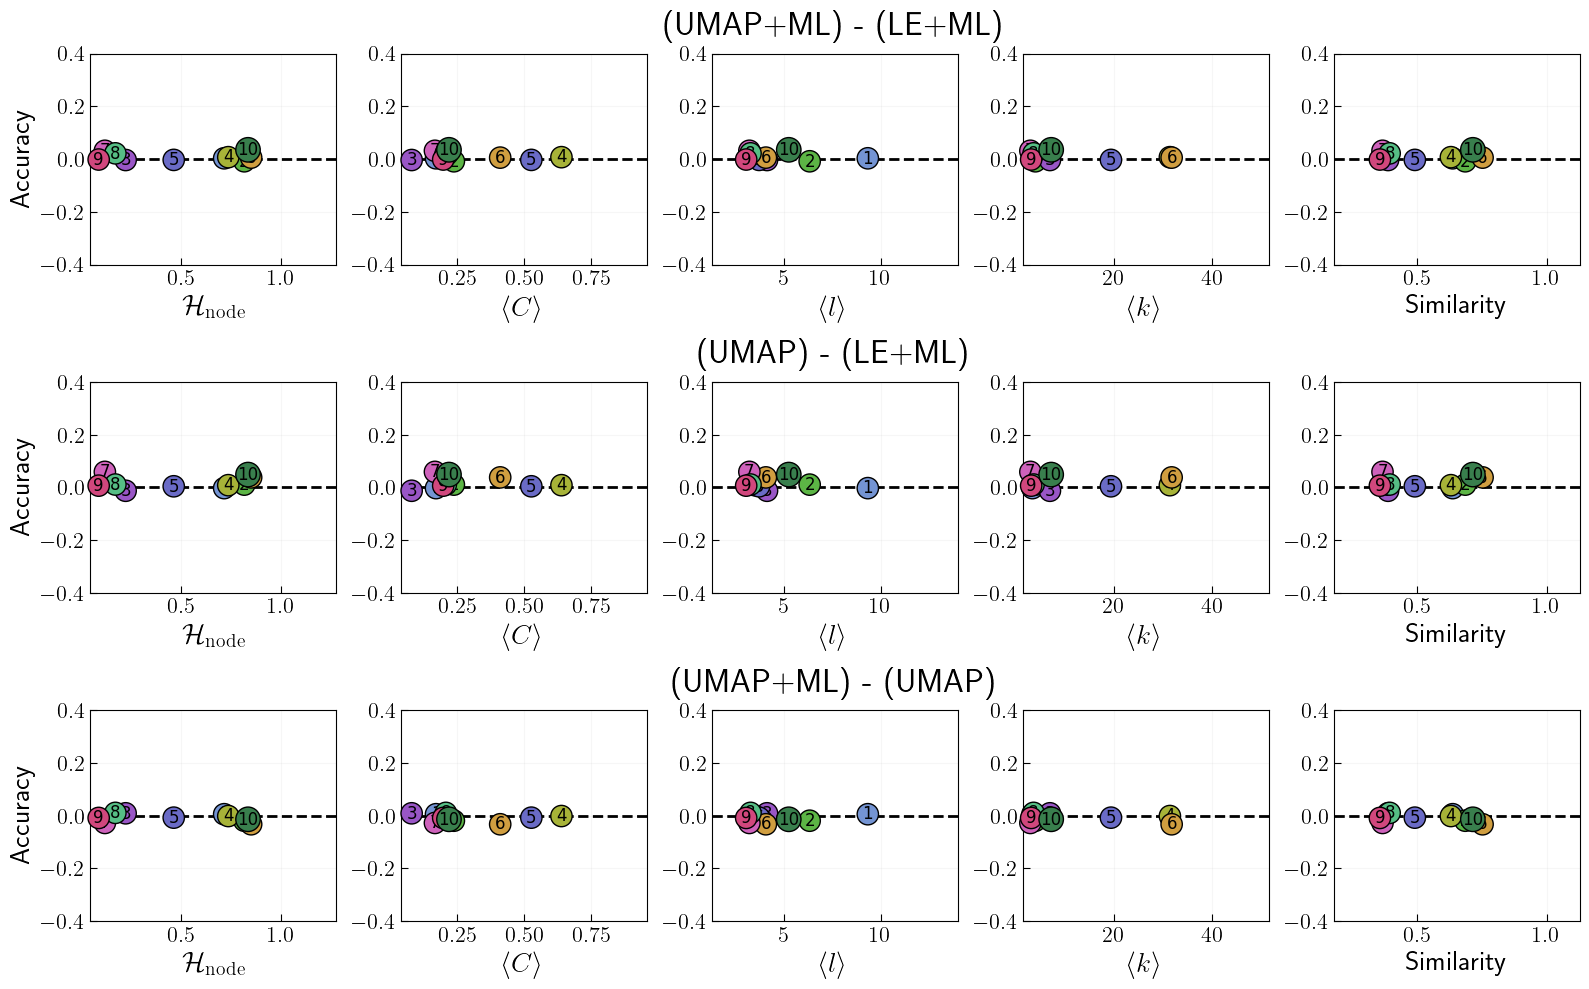

time: 2.33 s (started: 2023-05-10 15:37:34 +02:00)


In [38]:
def plot_all_options_difference(nc_res, title, ymin, ymax, i=1):
    plt.subplot(3, 5, i)
    plot_box_plot_per_option(nc_res, 'H_node')
    plt.ylim(ymin, ymax)
    plt.xlabel(r'$\mathcal{H}_{\mathrm{node}}$')
    plt.ylabel('Accuracy')
    plt.axhline(y=0, color='black', linestyle='--')

    plt.subplot(3, 5, i+1)
    plot_box_plot_per_option(nc_res, 'C')
    plt.xlabel(r'$\left<C\right>$')
    plt.ylim(ymin, ymax)
    plt.axhline(y=0, color='black', linestyle='--')

    plt.subplot(3, 5, i+2)
    plot_box_plot_per_option(nc_res, 'l')
    plt.xlabel(r'$\left<l\right>$')
    plt.ylim(ymin, ymax)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(title, y=1.05)
    
    plt.subplot(3, 5, i+3)
    plot_box_plot_per_option(nc_res, 'k')
    plt.xlabel(r'$\left<k\right>$')
    plt.ylim(ymin, ymax)
    plt.axhline(y=0, color='black', linestyle='--')

    plt.subplot(3, 5, i+4)
    plot_box_plot_per_option(nc_res, 'similarity') # it was 'r' previously
    plt.xlabel(r'Similarity')
    plt.ylim(ymin, ymax)
    plt.axhline(y=0, color='black', linestyle='--')

    
plt.figure(figsize=(16, 10))
plot_all_options_difference(nc_accuracy_umap_ml - nc_accuracy_le_ml, title='(UMAP+ML) - (LE+ML)', i=1, ymin=-0.4, ymax=0.4)
plot_all_options_difference(nc_accuracy_only_umap - nc_accuracy_le_ml, title='(UMAP) - (LE+ML)', i=6, ymin=-0.4, ymax=0.4)
plot_all_options_difference(nc_accuracy_umap_ml - nc_accuracy_only_umap, title='(UMAP+ML) - (UMAP)', i=11, ymin=-0.4, ymax=0.4)
plt.tight_layout()


In [39]:
import pickle

# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_louvain_labels_train_0_8.dat", 'wb') as f:
#     pickle.dump(nc_accuracy_le_ml, f)


# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_louvain_labels_train_0_8.dat", 'wb') as f:
#     pickle.dump(nc_accuracy_umap_ml, f)

# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_random_ml_louvain_labels_train_0_8.dat", 'wb') as f:
#     pickle.dump(nc_accuracy_random_ml, f)


# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_louvain_labels_train_0_8.dat", 'wb') as f:
#     pickle.dump(nc_accuracy_only_umap, f)
    

time: 1.04 ms (started: 2023-05-10 15:37:36 +02:00)


In [40]:
# import pickle

# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_louvain_labels_random_train_0_8.dat", 'wb') as f:
#     pickle.dump(nc_accuracy_le_ml, f)

# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_louvain_labels_random_train_0_8.dat", 'wb') as f:
#     pickle.dump(nc_accuracy_umap_ml, f)

# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_random_ml_louvain_labels_random_train_0_8.dat", 'wb') as f:
#     pickle.dump(nc_accuracy_random_ml, f)

# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_louvain_labels_random_train_0_8.dat", 'wb') as f:
#     pickle.dump(nc_accuracy_only_umap, f)
    

time: 4.77 ms (started: 2023-05-10 15:37:36 +02:00)
